In [1]:
import statsmodels.api as sm
import pandas as pd
from patsy import dmatrices

在statsmodels中，因变量与自变量分别对应内生变量（endog）与外生变量(exog)

In [2]:
df = pd.read_csv('Rdatasets-master/csv/HistData/Guerry.csv',
                index_col=0) 

In [3]:
vars = ['Department','Lottery','Literacy','Wealth','Region']
df = df[vars]

In [4]:
df = df.dropna()

In [5]:
df

,Department,Lottery,Literacy,Wealth,Region
1,Ain,41,37,73,E
2,Aisne,38,51,22,N
3,Allier,66,13,61,C
4,Basses-Alpes,80,46,76,E
5,Hautes-Alpes,79,69,83,E
...,...,...,...,...,...
81,Vendee,68,28,56,W
82,Vienne,40,25,68,W
83,Haute-Vienne,55,13,67,C
84,Vosges,14,62,82,E


patsy的dmatrices函数根据表达式重新设计y与X，其中X会：

- 将分类变量分解为一组指标变量。
- 在外生回归矩阵中增加一个常数。
- 返回的是熊猫数据缓存，而不是简单的numpy数组。这是很有用的，因为在报告结果时，数据类型允许状态模型转移元数据(例如变量名)。

In [32]:
y,X = dmatrices('Lottery ~ Literacy + Wealth + C(Region)',data=df,return_type='dataframe')

在statsmodels中拟合一个模型通常包括3个简单的步骤:

- 使用model类来描述模型
- 使用类方法拟合模型
- 使用摘要方法检查结果

In [33]:
X

,Intercept,C(Region)[T.E],C(Region)[T.N],C(Region)[T.S],C(Region)[T.W],Literacy,Wealth
1,1.0,1.0,0.0,0.0,0.0,37.0,73.0
2,1.0,0.0,1.0,0.0,0.0,51.0,22.0
3,1.0,0.0,0.0,0.0,0.0,13.0,61.0
4,1.0,1.0,0.0,0.0,0.0,46.0,76.0
5,1.0,1.0,0.0,0.0,0.0,69.0,83.0
...,...,...,...,...,...,...,...
81,1.0,0.0,0.0,0.0,1.0,28.0,56.0
82,1.0,0.0,0.0,0.0,1.0,25.0,68.0
83,1.0,0.0,0.0,0.0,0.0,13.0,67.0
84,1.0,1.0,0.0,0.0,0.0,62.0,82.0


In [34]:
mod = sm.OLS(y,X)
res = mod.fit()

In [35]:
print(res.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.287   
Dependent Variable: Lottery          AIC:                764.5986
Date:               2020-06-17 17:42 BIC:                781.6971
No. Observations:   85               Log-Likelihood:     -375.30 
Df Model:           6                F-statistic:        6.636   
Df Residuals:       78               Prob (F-statistic): 1.07e-05
R-squared:          0.338            Scale:              436.43  
-----------------------------------------------------------------
                 Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
-----------------------------------------------------------------
Intercept        38.6517   9.4563  4.0874 0.0001  19.8255 57.4778
C(Region)[T.E]  -15.4278   9.7273 -1.5860 0.1168 -34.7934  3.9378
C(Region)[T.N]  -10.0170   9.2603 -1.0817 0.2827 -28.4528  8.4188
C(Region)[T.S]   -4.5483   7.2789 -0.6249 0.5339 -19.0394  9.9429
C(Region)[T.W]  -10.0913   

结果对象具有很多有用的属性，例如：

In [36]:
res.params

Intercept         38.651655
C(Region)[T.E]   -15.427785
C(Region)[T.N]   -10.016961
C(Region)[T.S]    -4.548257
C(Region)[T.W]   -10.091276
Literacy          -0.185819
Wealth             0.451475
dtype: float64

In [37]:
res.rsquared

0.3379508691928822

输入dir(res)可以看到完整的属性与方法列表

诊断和规范测试

- statsmodel允许您执行一系列有用的回归诊断和规范测试。例如，对线性应用彩虹检验(原假设是恰当地将关系建模为线性):

In [18]:
sm.stats.linear_rainbow(res)

(0.847233997615691, 0.6997965543621644)

诚然，上面产生的输出不是很冗长，但我们从读取docstring中知道，第一个数字是f统计量，第二个是p值。

statsmodels还提供了图形功能。例如，我们可以为一组回归元绘制偏回归图:

In [19]:
print(sm.stats.linear_rainbow.__doc__)


    Rainbow test for linearity

    The null hypothesis is the fit of the model using full sample is the same
    as using a central subset. The alternative is that the fits are difference.
    The rainbow test has power against many different forms of nonlinearity.

    Parameters
    ----------
    res : RegressionResults
        A results instance from a linear regression.
    frac : float, default 0.5
        The fraction of the data to include in the center model.
    order_by : {ndarray, str, List[str]}, default None
        If an ndarray, the values in the array are used to sort the
        observations. If a string or a list of strings, these are interpreted
        as column name(s) which are then used to lexicographically sort the
        data.
    use_distance : bool, default False
        Flag indicating whether data should be ordered by the Mahalanobis
        distance to the center.
    center : {float, int}, default None
        If a float, the value must be in [0, 1] a

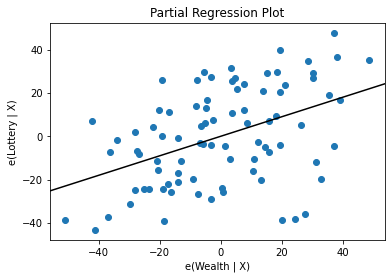

In [25]:
_ = sm.graphics.plot_partregress('Lottery','Wealth',['Region','Literacy'],data=df,obs_labels=False)